# Bad Credit? No Problem!

## Problem Description:
A client wishes to extend his/her company and provide an automated loan application service for individuals with bad credit. The client has historical data from 48842 of his/her customers, which he/she has obtained privacy rights to. The dataset contains information such as whether the individual's income is above \\$50K or less, educational level, occupation, marital status, gender, etc. Using his/her past business experience, the entrepreneur considers a loan application to be safe if the individual's income is above \\$50k and risky otherwise.

## Classifying an Individual's Income
For this project the goal is to predict whether an individual's income is $>\$50K$ or $\leq \$50K$ using binary classification. The data used comes from the [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/datasets/adult). The dataset contains 48842 instances, 14 attributes (numerical and categorical) as well as missing values. More information on the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/adult).

In [263]:
# for preprocessing
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# for preparing the data and tuning models
from sklearn.model_selection import train_test_split, GridSearchCV

# for feature engineering
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt

# models
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.ensemble import (BalancedBaggingClassifier, 
                               BalancedRandomForestClassifier, 
                               RUSBoostClassifier, 
                               EasyEnsembleClassifier)

# performance metrics
from sklearn.metrics import (confusion_matrix,
                             make_scorer,
                             roc_auc_score, 
                             roc_curve)

# for creating a pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
#warnings.filterwarnings("ignore")

sns.set()

# seed to ensure reproducibility
RANDOM_STATE = 0

# Loading the Data

In [264]:
DATA_PATH = "data/adult.csv"

In [265]:
def load_data(path):
    """ 
    Load the dataset at a given path.
    """
    data = pd.read_csv(path)
    return data

In [266]:
data = load_data(DATA_PATH)

data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# Exploratory Data Analysis

In [267]:
# variables to drop
DROP_COLUMNS = ["fnlwgt"]

In [268]:
data.drop(columns=DROP_COLUMNS, inplace=True)

In [269]:
data.rename(columns={"capital-gain": "capital_gain", 
                     "capital-loss": "capital_loss",
                     "hours-per-week": "hours_per_week",
                     "marital-status": "marital_status",
                     "native-country": "native_country"
                    }, inplace=True)

In [270]:
data.to_csv("data/train.csv")

In [261]:
data.describe()

,age,educational-num,capital_gain,capital_loss,hours_per_week,income
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   education        48842 non-null  object
 3   educational-num  48842 non-null  int64 
 4   marital_status   48842 non-null  object
 5   occupation       48842 non-null  object
 6   relationship     48842 non-null  object
 7   race             48842 non-null  object
 8   gender           48842 non-null  object
 9   capital_gain     48842 non-null  int64 
 10  capital_loss     48842 non-null  int64 
 11  hours_per_week   48842 non-null  int64 
 12  native_country   48842 non-null  object
 13  income           48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


## Missing Values

In [216]:
data.isnull().sum()

age                0
workclass          0
education          0
educational-num    0
marital_status     0
occupation         0
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hours_per_week     0
native_country     0
income             0
dtype: int64

Perhaps missing values are encoded as some string or number...

In [217]:
# extract numerical features
numerical_features = [var for var in data.columns if data[var].dtypes != 'O']

numerical_features

['age', 'educational-num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [218]:
# extract categorical features 
categorical_features = [var for var in data.columns if var not in numerical_features and var != 'income']

categorical_features

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native_country']

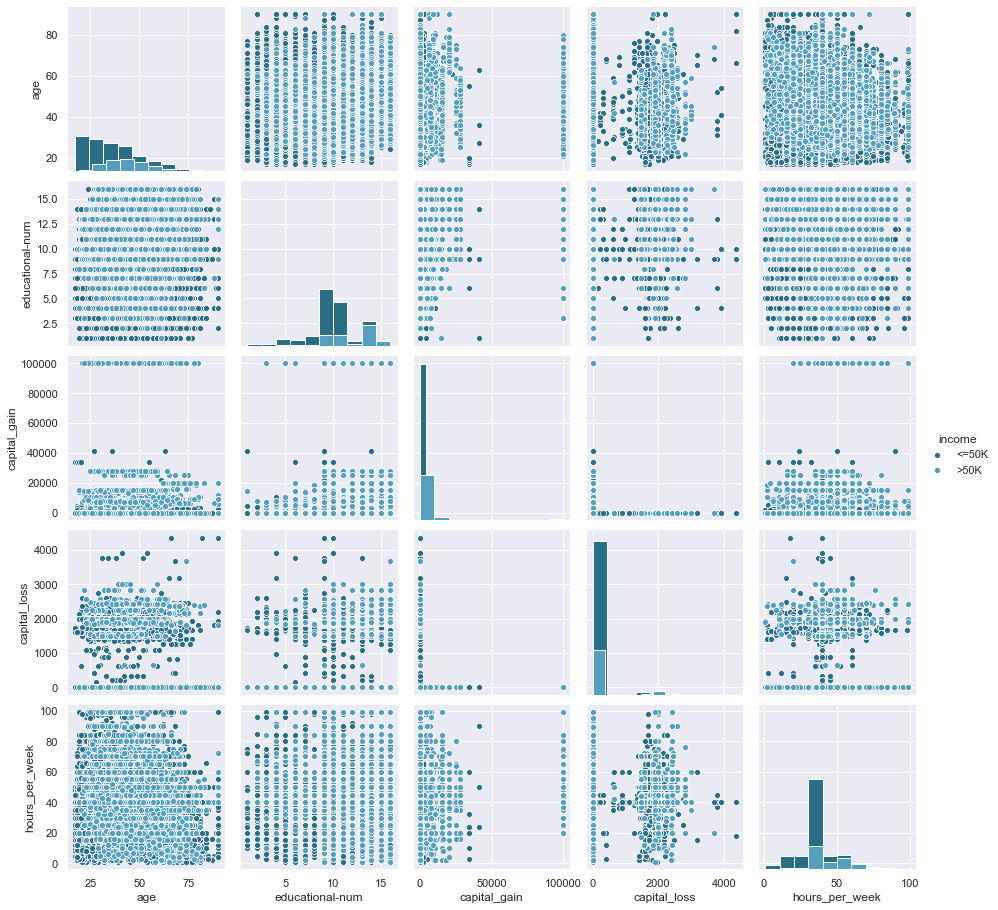

In [219]:
# explore the distribution of numerical features
fig = sns.pairplot(data[numerical_features+['income']], hue='income', palette='PuBuGn_d', diag_kind='hist')
plt.show()

There doesn't appear to be any correlation between any of the numerical variables.

The distribution of some variables seems highly skewed and far from normal. Although this isn't an issue for all the methods we will compare, it won't affect to engineer these variables in order to bring the distributions closer to normal.

It seems that, in general, **income** increases with **age, educational-num,** and **hours-per-week**, which makes sense. This might suggest that a linear model might perform well.

Let's vizualize the distributions of the numerical variables in more detail.

In [220]:
def plot_numerical(data, features):
    """
    Visualize the distribution of each numerical variable.
    
    Keyword arguments:
    data -- the dataset
    features -- the variables under consideration
    """
    for var in features:
        fig = sns.distplot(data[var], bins=10, kde=False)
        plt.title(var)
        plt.show()

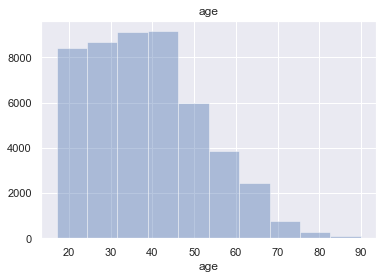

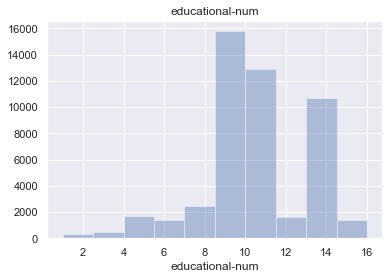

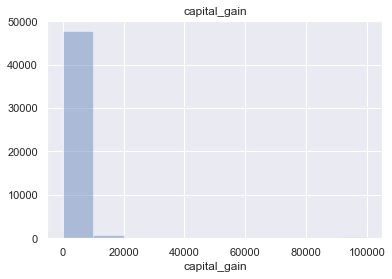

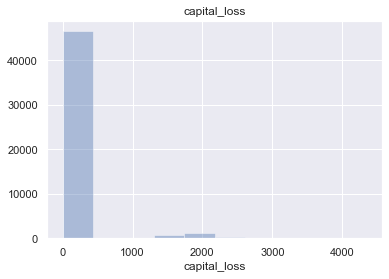

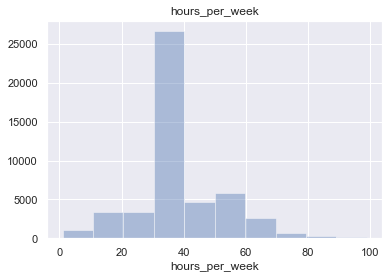

In [221]:
plot_numerical(data, numerical_features)

In [222]:
# explore the cardinalities of categorical variables
def print_cardinality(data, features):
    """
    Print the unique values and cardinality for each variable.
    
    Keyword arguments:
    data -- the dataset
    features -- the features to print the unique values and cardinality for
    """
    for var in features:
        print("Variable Name: " + var)
        print(data[var].value_counts())
        print("Cardinality:", len(data[var].unique()))
        print("------------------------------------ \n")

In [223]:
print_cardinality(data, categorical_features)

Variable Name: workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
Cardinality: 9
------------------------------------ 

Variable Name: education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64
Cardinality: 16
------------------------------------ 

Variable Name: marital_status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-sp

As suspected, missing values are encoded as `?`. Let's replace them with the string ` "Missing" `

In [224]:
# replace "?" with "Missing"
data.replace('?', 'Missing', inplace=True)

In [225]:
# check that it worked
print_cardinality(data, categorical_features)

Variable Name: workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
Missing              2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
Cardinality: 9
------------------------------------ 

Variable Name: education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64
Cardinality: 16
------------------------------------ 

Variable Name: marital_status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-sp

In [226]:
# extract categorical variables with missing values
vars_with_na = [var for var in categorical_features if "Missing" in data[var].values]

In [227]:
vars_with_na

['workclass', 'occupation', 'native_country']

In [228]:
def print_missing_pct(data, features, missing_key):
    """
    Print the percentage of values that is missing.
    
    Keyword arguments:
    data -- the dataset
    features -- the features to print the percentage of missing values for
    missing_key -- the string encoding of a missing value
    """
    for var in features:
        print("Variable Name: ", var)
        print("Percentage of missing values: ", np.round(data[var].str.contains(missing_key).mean() * 100, 3), "%")
        print("------------------------------------- \n")

In [229]:
print_missing_pct(data, vars_with_na, "Missing")

Variable Name:  workclass
Percentage of missing values:  5.731 %
------------------------------------- 

Variable Name:  occupation
Percentage of missing values:  5.751 %
------------------------------------- 

Variable Name:  native_country
Percentage of missing values:  1.755 %
------------------------------------- 



In [230]:
def analyze_na_value(data, var, missing_key, output_var):
    """
    Compare the payback rate for missing values vs avaiable values.
    
    Keyword arguments:
    data -- the dataset
    var -- the variable to plot
    missing_key -- the string encoding of a missing value
    output_var -- the output variable
    """
    data = data.copy()
    
    # create a flag to separate the missing values from the rest
    data[var] = np.where(data[var]==missing_key, "Missing", "Not Missing")
    data[output_var] = np.where(data[output_var]==">50K", 1, 0)
    
    # compare the output variable where the observations are values are 
    # missing vs where value is available
    fig = sns.catplot(x=var, y=output_var, data=data, kind="bar", palette="Blues_r", ci=None)
    fig.set_axis_labels(var, "Payback Rate")
    
    plt.title(var)
    plt.show()
    

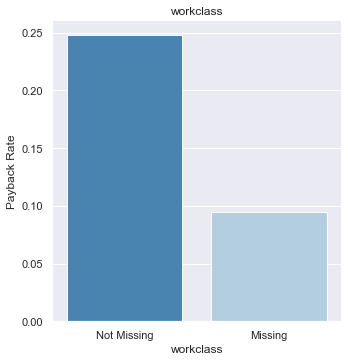

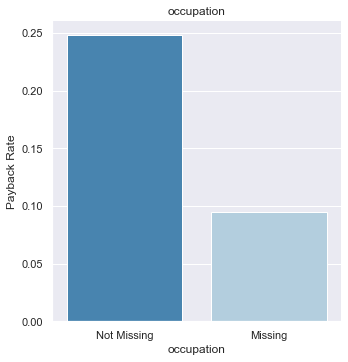

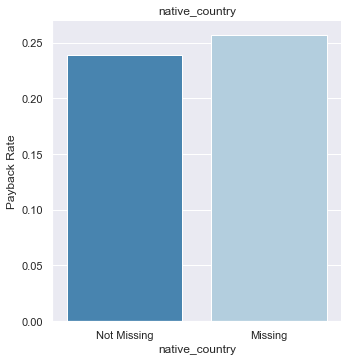

In [231]:
for var in vars_with_na:
    analyze_na_value(data, var, "Missing", "income")

The payback rate where the information is missing differs from the payback rate where information exists.

We will capture this information when we engineer the variables.

## Exploring Rare Values
Let's explore which categorical variables contain values that are too infrequent in the dataset and thus can be considered as rare.

In [232]:
def plot_categorical(data, features):
    """
    For each categorical variable, visualize the label counts 
    for each category in the output variable.
    
    Keyword arguments:
    data -- the dataset
    features -- the variables under consideration
    """
    for var in features:
        fig = sns.catplot(y=var, data=data, kind='count', hue='income', palette="Blues_r")
        
        plt.title(var)
        plt.show()

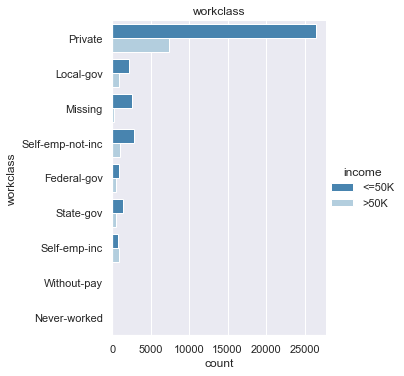

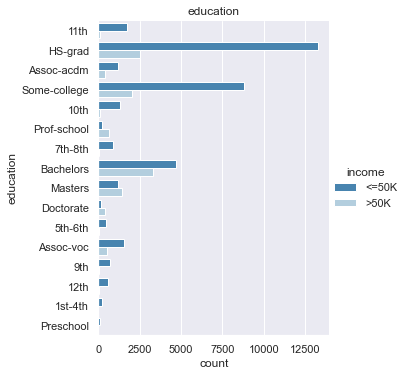

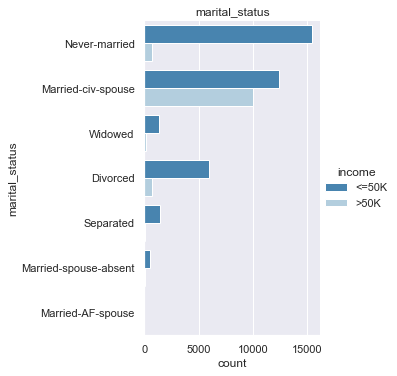

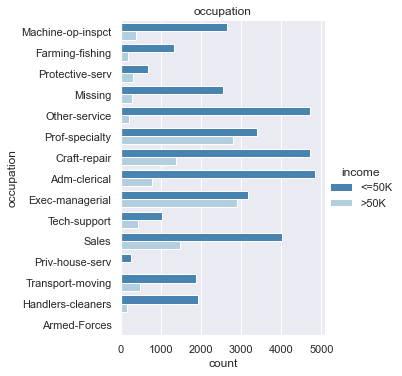

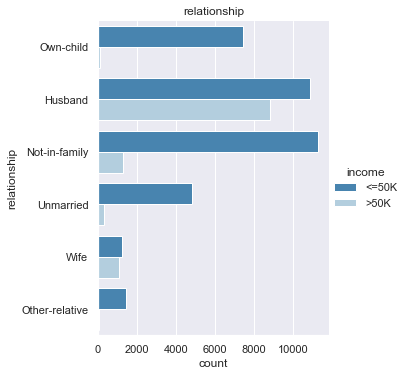

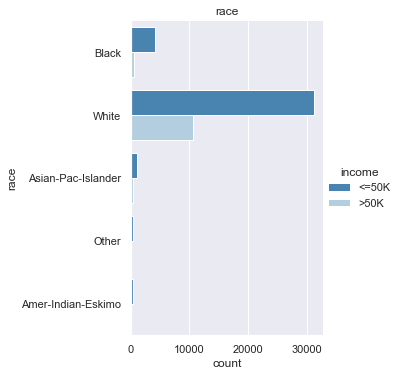

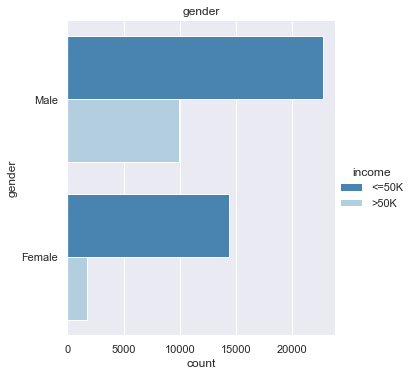

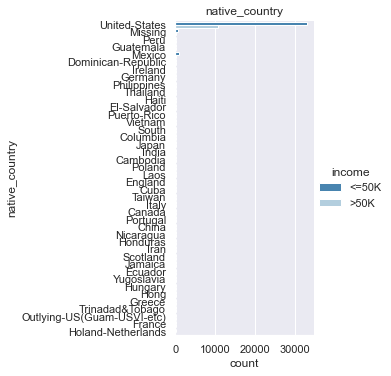

In [233]:
plot_categorical(data, categorical_features)

In [234]:
def find_frequent_labels(data, var, threshold):
    """
    Finds the labels that are shared by more than a certain
    percentage of the observations in the dataset for a given variable.
    
    Keyword arguments:
    data -- the dataset
    var -- the variable under consideration
    threshold -- the threshold separates frequent labels from infrequent labels 
    """
    data = data.copy()

    tmp = data.groupby(var)['income'].count() / len(data)

    return tmp[tmp > threshold].index

In [235]:
def print_num_rare_labels(data, features, threshold):
    """
    Print the number and percentage of rare labels for a given variable.
    
    Keyword arguments:
    data -- the dataset
    features -- the variables under consideration
    threshold -- the threshold separates frequent labels from infrequent labels 
    
    Returns:
    vars_with_rare -- the variables with rare labels
    """
    vars_with_rare = []
    
    for var in features:
        num_labels = len(data[var].unique())
        num_rare_labels = num_labels -len(find_frequent_labels(data, var, threshold))
        rare_pct = num_rare_labels / len(data[var].unique())
        print("Variable Name: ", var)
        print("Number of rare labels: ", num_rare_labels)
        print("Percentage of rare labels: ", np.round(rare_pct*100, 2), "%")
        print("----------------------------------- \n")
        
        if num_rare_labels > 0:
            vars_with_rare.append(var)
            
    return vars_with_rare

In [236]:
# extract the variables that contain rare labels, defining rare as 
# those labels that make up less than 3% of the observations
vars_with_rare = print_num_rare_labels(data, categorical_features, 0.03)
print("Variables with rare labels: ", vars_with_rare)

Variable Name:  workclass
Number of rare labels:  3
Percentage of rare labels:  33.33 %
----------------------------------- 

Variable Name:  education
Number of rare labels:  9
Percentage of rare labels:  56.25 %
----------------------------------- 

Variable Name:  marital_status
Number of rare labels:  2
Percentage of rare labels:  28.57 %
----------------------------------- 

Variable Name:  occupation
Number of rare labels:  4
Percentage of rare labels:  26.67 %
----------------------------------- 

Variable Name:  relationship
Number of rare labels:  0
Percentage of rare labels:  0.0 %
----------------------------------- 

Variable Name:  race
Number of rare labels:  2
Percentage of rare labels:  40.0 %
----------------------------------- 

Variable Name:  gender
Number of rare labels:  0
Percentage of rare labels:  0.0 %
----------------------------------- 

Variable Name:  native_country
Number of rare labels:  41
Percentage of rare labels:  97.62 %
----------------------------

It seems that most of the categorical variables contain quite a bit of rare labels.

We will capture this information when we engineer the variables.

# Feature Engineering

In [237]:
# first tranform the target with 0 and 1
data['income'] = np.where(data['income']=='>50K', 1, 0)

In [238]:
ordinal_features = ['education']

In [239]:
categorical_features.remove('education')

In [240]:
numerical_features.remove('educational-num')

In [241]:
features = numerical_features + categorical_features + ordinal_features
target = 'income'

In [242]:
features

['age',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native_country',
 'education']

In [243]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    data[features],  # predictors
    data[target],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=RANDOM_STATE)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((39073, 12), (9769, 12))

## Missing Data Encoding
It might be the case that the missing values might be encoded as a variety of things. Let's assume that the encoding for missing values is either `"?"`, `Null`, or `white spaces`.

In [244]:
def encode_missing(data, features, replace_with="Missing"):
    """ 
    Replace "?", Null, and an arbitrary amount of white spaces with 
    a given encoding.
    
    Keyword arguments:
    data -- the dataset
    features -- the variables with missing values
    replace_with -- the string to encode missing values with
    
    Returns:
    data -- the new dataset with encoded missing values
    
    
    """
    data = data.copy()
    
    for var in features:
        data[var] = data[var].str.strip()     # trim all white spaces
        data[var] = np.where(data[var]=='', replace_with, data[var])
        data[var] = np.where(data[var]=='?', replace_with, data[var])
        data[var] = np.where(data[var].isnull(), replace_with, data[var])
        
    return data

In [245]:
X_train = encode_missing(X_train, vars_with_na)
X_test = encode_missing(X_test, vars_with_na)

## Rare Label Encoding
Let's replace all infrequent labels with ` "Other" ` for variables with cardinality >= 4

In [246]:
vars_with_rare

['workclass',
 'education',
 'marital_status',
 'occupation',
 'race',
 'native_country']

In [247]:
# set up the encoder, with threshold (tol) of 3%
rare_encoder = ce.RareLabelCategoricalEncoder(tol=0.03, 
                                            n_categories=4,
                                            variables=vars_with_rare,
                                            replace_with='Other', 
                                            return_object=True)

# fit the encoder to the training data
rare_encoder.fit(X_train)

# transform the training and test data
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

rare_encoder.encoder_dict_

{'workclass': Index(['Private', 'Self-emp-not-inc', 'Local-gov', 'Missing', 'State-gov',
        'Self-emp-inc'],
       dtype='object'),
 'education': Index(['HS-grad', 'Some-college', 'Bachelors', 'Masters', 'Assoc-voc', '11th',
        'Assoc-acdm'],
       dtype='object'),
 'marital_status': Index(['Married-civ-spouse', 'Never-married', 'Divorced', 'Widowed',
        'Separated'],
       dtype='object'),
 'occupation': Index(['Craft-repair', 'Exec-managerial', 'Prof-specialty', 'Sales',
        'Adm-clerical', 'Other-service', 'Machine-op-inspct', 'Missing',
        'Transport-moving', 'Handlers-cleaners', 'Farming-fishing'],
       dtype='object'),
 'race': Index(['White', 'Black', 'Asian-Pac-Islander'], dtype='object'),
 'native_country': Index(['United-States'], dtype='object')}

In [248]:
for var in vars_with_rare:
    print(var)
    train_temp = X_train[var].unique().copy()
    train_temp.sort()
    test_temp = X_test[var].unique().copy()
    test_temp.sort()
    print(train_temp)
    print(test_temp)
    print("-------------------------------------------------------------\n")
    assert(len(train_temp) == len(test_temp))
    assert(len(set(train_temp) - set(test_temp)) == 0)

workclass
['Local-gov' 'Missing' 'Other' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov']
['Local-gov' 'Missing' 'Other' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov']
-------------------------------------------------------------

education
['11th' 'Assoc-acdm' 'Assoc-voc' 'Bachelors' 'HS-grad' 'Masters' 'Other'
 'Some-college']
['11th' 'Assoc-acdm' 'Assoc-voc' 'Bachelors' 'HS-grad' 'Masters' 'Other'
 'Some-college']
-------------------------------------------------------------

marital_status
['Divorced' 'Married-civ-spouse' 'Never-married' 'Other' 'Separated'
 'Widowed']
['Divorced' 'Married-civ-spouse' 'Never-married' 'Other' 'Separated'
 'Widowed']
-------------------------------------------------------------

occupation
['Adm-clerical' 'Craft-repair' 'Exec-managerial' 'Farming-fishing'
 'Handlers-cleaners' 'Machine-op-inspct' 'Missing' 'Other' 'Other-service'
 'Prof-specialty' 'Sales' 'Transport-moving']
['Adm-clerical' 'Craft-repair' 'Exec-managerial' 'Farming

## Categorical Encoding

In [249]:
categorical_features

['workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native_country']

In [250]:
data[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       48842 non-null  object
 1   marital_status  48842 non-null  object
 2   occupation      48842 non-null  object
 3   relationship    48842 non-null  object
 4   race            48842 non-null  object
 5   gender          48842 non-null  object
 6   native_country  48842 non-null  object
dtypes: object(7)
memory usage: 2.6+ MB


## Target-Guided Ordinal Categorical Encoding
The **Target-Guided Ordinal Categorical Encoding** technique will be used encode the ordinal categorical variables, which creates a monotonic relationship between the categorical variables and the target.

In [251]:
# set up the encoder
or_encoder = ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                         variables=ordinal_features)

# fit the encoder to the training data
or_encoder.fit(X_train, y_train)

# transform the training and test data
X_train = or_encoder.transform(X_train)
X_test = or_encoder.transform(X_test)

or_encoder.encoder_dict_

{'education': {'11th': 0,
  'HS-grad': 1,
  'Some-college': 2,
  'Other': 3,
  'Assoc-voc': 4,
  'Assoc-acdm': 5,
  'Bachelors': 6,
  'Masters': 7}}

## One Hot Categorical Encoding
The **One-Hot Encoding** technique will be used to encode the nominal categorical variables.

In [252]:
# set up the encoder
oh_encoder = ce.OneHotCategoricalEncoder(variables=categorical_features,
                                        drop_last=True)

# fit the encoder to the training data
oh_encoder.fit(X_train, y_train)

# transform the training and test data
X_train = oh_encoder.transform(X_train)
X_test = oh_encoder.transform(X_test)

oh_encoder.encoder_dict_

{'workclass': ['Missing',
  'Private',
  'State-gov',
  'Self-emp-inc',
  'Local-gov',
  'Self-emp-not-inc'],
 'marital_status': ['Never-married',
  'Married-civ-spouse',
  'Divorced',
  'Widowed',
  'Separated'],
 'occupation': ['Missing',
  'Craft-repair',
  'Other',
  'Prof-specialty',
  'Other-service',
  'Exec-managerial',
  'Adm-clerical',
  'Sales',
  'Handlers-cleaners',
  'Machine-op-inspct',
  'Farming-fishing'],
 'relationship': ['Own-child',
  'Husband',
  'Unmarried',
  'Not-in-family',
  'Wife'],
 'race': ['Black', 'White', 'Asian-Pac-Islander'],
 'gender': ['Female'],
 'native_country': ['United-States']}

In [253]:
X_train.columns

Index(['age', 'capital_gain', 'capital_loss', 'hours_per_week', 'education',
       'workclass_Missing', 'workclass_Private', 'workclass_State-gov',
       'workclass_Self-emp-inc', 'workclass_Local-gov',
       'workclass_Self-emp-not-inc', 'marital_status_Never-married',
       'marital_status_Married-civ-spouse', 'marital_status_Divorced',
       'marital_status_Widowed', 'marital_status_Separated',
       'occupation_Missing', 'occupation_Craft-repair', 'occupation_Other',
       'occupation_Prof-specialty', 'occupation_Other-service',
       'occupation_Exec-managerial', 'occupation_Adm-clerical',
       'occupation_Sales', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Farming-fishing',
       'relationship_Own-child', 'relationship_Husband',
       'relationship_Unmarried', 'relationship_Not-in-family',
       'relationship_Wife', 'race_Black', 'race_White',
       'race_Asian-Pac-Islander', 'gender_Female',
       'native_country_United-State

In [254]:
X_test.columns

Index(['age', 'capital_gain', 'capital_loss', 'hours_per_week', 'education',
       'workclass_Missing', 'workclass_Private', 'workclass_State-gov',
       'workclass_Self-emp-inc', 'workclass_Local-gov',
       'workclass_Self-emp-not-inc', 'marital_status_Never-married',
       'marital_status_Married-civ-spouse', 'marital_status_Divorced',
       'marital_status_Widowed', 'marital_status_Separated',
       'occupation_Missing', 'occupation_Craft-repair', 'occupation_Other',
       'occupation_Prof-specialty', 'occupation_Other-service',
       'occupation_Exec-managerial', 'occupation_Adm-clerical',
       'occupation_Sales', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Farming-fishing',
       'relationship_Own-child', 'relationship_Husband',
       'relationship_Unmarried', 'relationship_Not-in-family',
       'relationship_Wife', 'race_Black', 'race_White',
       'race_Asian-Pac-Islander', 'gender_Female',
       'native_country_United-State

In [255]:
assert len(X_train.columns) == len(X_test.columns)
assert len(set(X_train.columns) - set(X_test.columns)) == 0

## Transforming Numerical Variables
Since some variables have the value of 0, we can't use a log transformation. Let's use a **Yeo-Johnson** transformatiom, which can handle negative and positive values, including 0.

In [256]:
# create transformer object
pt = PowerTransformer(method='yeo-johnson', standardize=False)

# fit transformer to training data
pt.fit(X_train[numerical_features])

# transform the training and test data
X_train[numerical_features] = pt.transform(X_train[numerical_features])
X_test[numerical_features] = pt.transform(X_test[numerical_features])

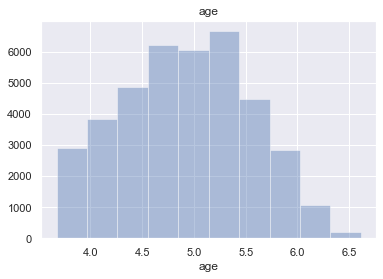

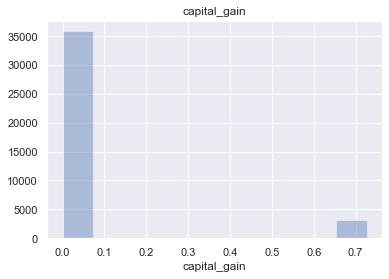

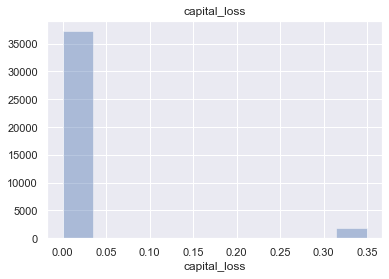

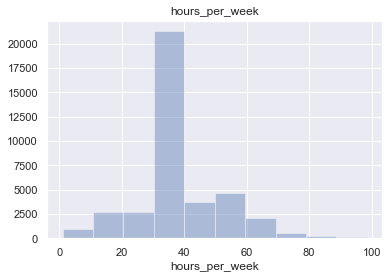

In [257]:
plot_numerical(X_train, numerical_features)

There seems to be some improvement, though not much.

In [258]:
FEATURES = X_train.columns
FEATURES

Index(['age', 'capital_gain', 'capital_loss', 'hours_per_week', 'education',
       'workclass_Missing', 'workclass_Private', 'workclass_State-gov',
       'workclass_Self-emp-inc', 'workclass_Local-gov',
       'workclass_Self-emp-not-inc', 'marital_status_Never-married',
       'marital_status_Married-civ-spouse', 'marital_status_Divorced',
       'marital_status_Widowed', 'marital_status_Separated',
       'occupation_Missing', 'occupation_Craft-repair', 'occupation_Other',
       'occupation_Prof-specialty', 'occupation_Other-service',
       'occupation_Exec-managerial', 'occupation_Adm-clerical',
       'occupation_Sales', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Farming-fishing',
       'relationship_Own-child', 'relationship_Husband',
       'relationship_Unmarried', 'relationship_Not-in-family',
       'relationship_Wife', 'race_Black', 'race_White',
       'race_Asian-Pac-Islander', 'gender_Female',
       'native_country_United-State

## Scaling Features

In [259]:
# create a scaler object
scaler = MinMaxScaler()

# fit scaler to training data
scaler.fit(X_train)

# transform the training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modelling
We will compare the performance of a variety of parametric and nonparametric models.

## Evaluating Model Performance
To see how the model is doing in the context of predictive power on future (unseen) data, it's important to keep in mind the problem we're trying to solve and use meaningful and relevant metrics. 

+ **[Confusion Matrix (Normalized)](https://en.wikipedia.org/wiki/Confusion_matrix)**: A clean and unambiguous way to present the prediction results of a classifier, it shows the proportion of observations that were correctly and incorrectly classified by the classifier.

+ **[AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)**: the area under the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. We are concerned with maximizing the TPR and minimizing the FPR, which is equivalent to maximizing the AUC.


Since we're working with an imbalanced dataset, accuracy wouldn't be the best metric for evaluating the performance of the models.

In [260]:
def evaluate_model(model, X_train, X_test, y_test, y_train):
    """
    Summarize evaluation metrics for a given model.
    """
    
    yhat = model.predict(X_test)
    y_hat_train = model.predict(X_train)
    probs_train = model.predict_proba(X_train)
    probs_test = model.predict_proba(X_test)
    try:
        probs_test = model.predict_proba(X_test)
        aucc_train = roc_auc_score(y_train, probs_train[:,1])
        aucc_test = roc_auc_score(y_test, probs_test[:,1])
        fpr, tpr, _ = roc_curve(y_test, probs_test[:,1])
        print('AUC on Training Set: ', np.round(aucc_train,3))    
        print('AUC on Test Set: ', np.round(aucc_test,3))
    except:
        pass
    

    # normalized confusion matrix
    ncm = confusion_matrix(y_test, yhat, normalize='true')   
    fig, ax = plt.subplots(1,2,figsize=(16, 5))
    sns.heatmap(ncm, annot=True, cmap='Blues', fmt='.2g', ax=ax[0])
    ax[0].set_title('Normalized Confusion Matrix', fontdict=dict(size=14))
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    ax[0].set_ylim(len(ncm), 0)
    
    # ROC curve
    sns.lineplot(fpr, tpr, ax=ax[1], label='ROC  curve (AUC = ' + str(np.round(aucc_test,3)) +')')
    sns.lineplot([0,1], [0,1], ax=ax[1], label='Random')
    ax[1].lines[1].set_linestyle("--")
    ax[1].set_title('Receiver Operating Characteristic (ROC) Curve', fontdict=dict(size=14))
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylim(-0.05, 1.05)
    plt.show()

## Logistic Regression

### Benchmark Model
Let's use a logistic regression model with default hyperparameters as our benchmark model.

In [54]:
# logistic regression model with default hyperparameters
log_model = LogisticRegression(random_state=RANDOM_STATE, 
                               n_jobs=-1,
                               class_weight='balanced')

# train the model
log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

AUC on Training Set:  0.892
AUC on Test Set:  0.892


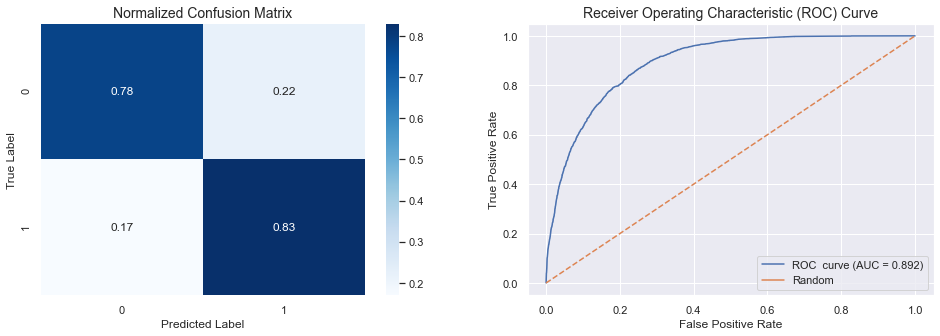

In [55]:
evaluate_model(log_model, X_train, X_test, y_test, y_train)

## Hyperparameter Tuning
Let's see how much we can improve the logistic regression model by

In [710]:
# grid of hyperparameters to search over
log_param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : [10, 1, 0.1, 0.5, 0.01, 0.001],
    'solver' : ['liblinear'],
    'class_weight': [None, 'balanced']},
]

# Create a classifier object with logistic regression classifier and 
# hyperparameter candidiates, use 5-fold CV
log_tuned = GridSearchCV(estimator=LogisticRegression(random_state=RANDOM_STATE),
                         param_grid=log_param_grid, 
                         cv=5,
                         n_jobs=-1, 
                         return_train_score=True)

# Train the classifier 
log_tuned.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [10, 1, 0.1, 0.5, 0.01, 0.001],
                          'class_weight': [None, 'balanced'],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

AUC on Training Set:  0.892
AUC on Test Set:  0.891


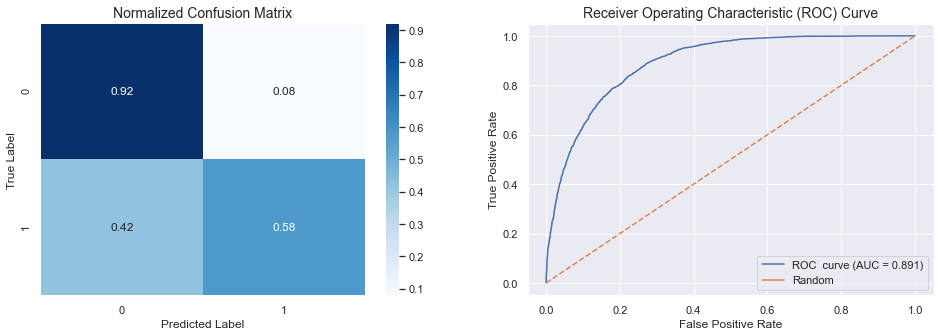

In [711]:
evaluate_model(log_tuned.best_estimator_, X_train, X_test, y_test, y_train)

## Support Vector Machine

In [712]:
# SVM model
svm = SVC(kernel='linear', 
          class_weight='balanced',
          probability=True,
          random_state=RANDOM_STATE)

# train the model
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

AUC on Training Set:  0.884
AUC on Test Set:  0.885


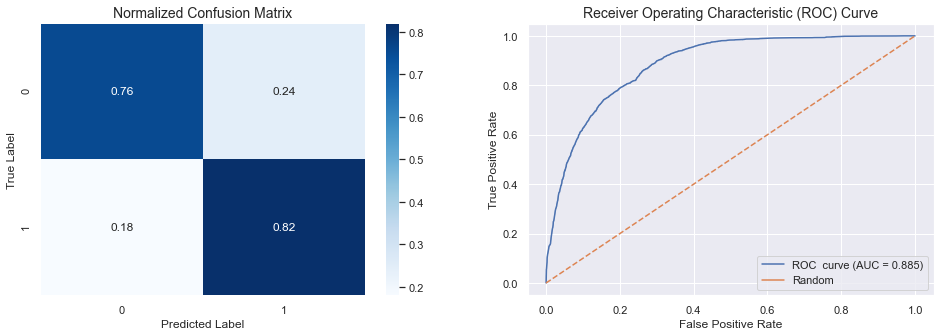

In [713]:
evaluate_model(svm, X_train, X_test, y_test, y_train)

In [714]:
# grid of hyperparameters to search over
svm_grid = [
    {'C' : [50, 10, 5, 1, 0.1, 0.01],
    'kernel' : ['linear'],
    'class_weight': ['balanced'],
    'probability': [True]}
]

# Create a classifier object with logistic regression classifier and 
# hyperparameter candidiates, use 5-fold CV
svm_tuned = GridSearchCV(estimator=SVC(random_state=RANDOM_STATE), 
                        param_grid=svm_grid, 
                        cv=5,
                        n_jobs=-1, 
                        return_train_score=True)

# Train the classifier 
svm_tuned.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [50, 10, 5, 1, 0.1, 0.01],
                          'class_weight': ['balanced'], 'kernel': ['linear'],
                          'probability': [True]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

AUC on Training Set:  0.885
AUC on Test Set:  0.885


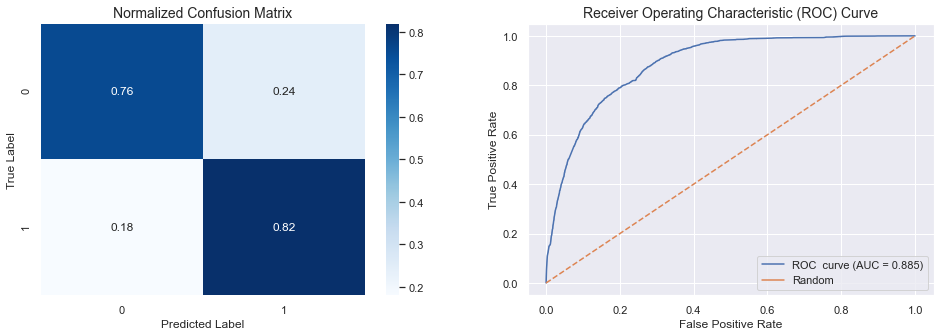

In [715]:
evaluate_model(svm_tuned.best_estimator_, X_train, X_test, y_test, y_train)

## Decision Tree

In [716]:
# create decision tree object
ct = tree.DecisionTreeClassifier()

# train the decision tree 
ct.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [717]:
print("The Tree's depth is: ", ct.get_depth())
print("The Number of leaf nodes in the tree is: ", ct.get_n_leaves())

The Tree's depth is:  41
The Number of leaf nodes in the tree is:  7818


AUC on Training Set:  0.998
AUC on Test Set:  0.735


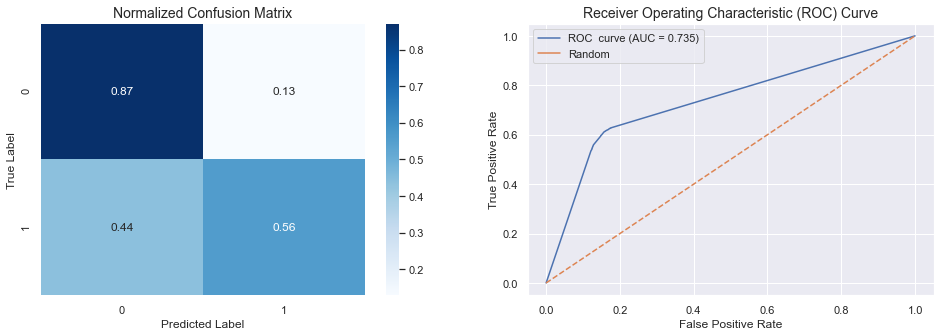

In [718]:
evaluate_model(ct, X_train, X_test, y_test, y_train)

In [719]:
# grid of hyperparameters to search over
tree_grid = [
  {'max_depth': [5, 10, 20, 30, 40, 50], 
   'min_samples_split': [2, 10, 20]}
]

# Create a classifier object with a decision tree classifier and 
# hyperparameter candidates, use 5-fold CV
ct_tuned = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=RANDOM_STATE), 
                        param_grid=tree_grid,
                        cv=5,
                        n_jobs=-1, 
                        return_train_score=True)

# Train the classifier 
ct_tuned.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'max_depth': [5, 10, 20, 30, 40, 50],
                          'min_samples_split': [2, 10, 20]}],
   

In [720]:
print("The Tree's depth is: ", ct_tuned.best_estimator_.get_depth())
print("The Number of leaf nodes in the tree is: ", ct_tuned.best_estimator_.get_n_leaves())

The Tree's depth is:  10
The Number of leaf nodes in the tree is:  396


AUC on Training Set:  0.908
AUC on Test Set:  0.879


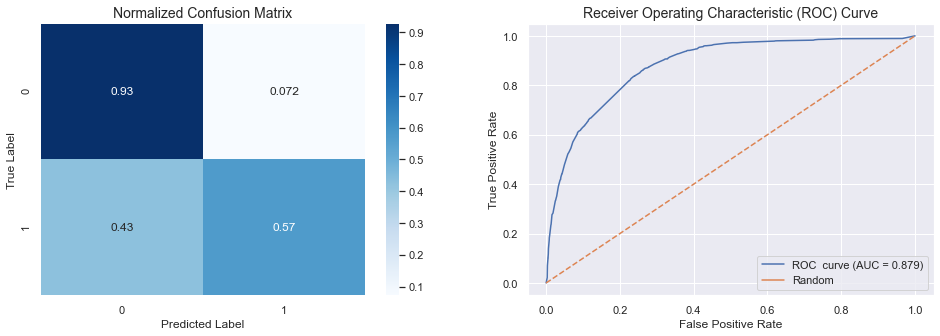

In [721]:
evaluate_model(ct_tuned.best_estimator_, X_train, X_test, y_test, y_train)

The tuned decision tree seems to have better performance and is overfitting a lot less than the default-parameter tree. Let's explore other models.

## Bagging
As we observed when evaluating the decision tree, the model was able to obtain almost 0 training error (really high training AUC score), but much higher test error. This indicates that the model was overfitting. Although the model was able to fit the training data somewhat well (**low bias**), it didn't generalize well to new data (**high variance**).  

What if we "average" a high number, m, of independent estimators with low bias in attempts to alleviate the high variance problem? If we have m independent random variables with variance $\sigma^2$, then their average will have variance $\frac{\sigma^2}{m}$. This is basically what [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) attempts to do, except we don't have m datasets to train m estimators, so we take bootstrap samples with replacement from our training to simulate the population of all training datasets. In addition, the term "averaging" doesn't make much sense in the context of classification, so bagging is applied to classification trees by taking a majority vote among all m estimators.

For this step, I will use a particular type of bagging called [balanced bagging](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html), which uses random under sampling to alleviate imbalance between the classes. This way, the majority class is not favoured as it was seen with a single decision tree.

In [722]:
# define the hyperparamter search space
bag_grid = [
  {'n_estimators': [20, 50, 100, 150, 250, 500]}
]

# Create a classifier object with the a baggin classifier and 
# hyperparameter candidates, use 5-fold CV
bag_tuned = GridSearchCV(estimator=BalancedBaggingClassifier(random_state=RANDOM_STATE), 
                         param_grid=bag_grid,
                         cv=5,
                         n_jobs=-1, 
                         return_train_score=True)

# Train the classifier 
bag_tuned.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=BalancedBaggingClassifier(base_estimator=None,
                                                 bootstrap=True,
                                                 bootstrap_features=False,
                                                 max_features=1.0,
                                                 max_samples=1.0,
                                                 n_estimators=10, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=0,
                                                 replacement=False,
                                                 sampling_strategy='auto',
                                                 verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'n_estimators': [20, 50, 100, 150, 250, 500]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True

AUC on Training Set:  0.991
AUC on Test Set:  0.88


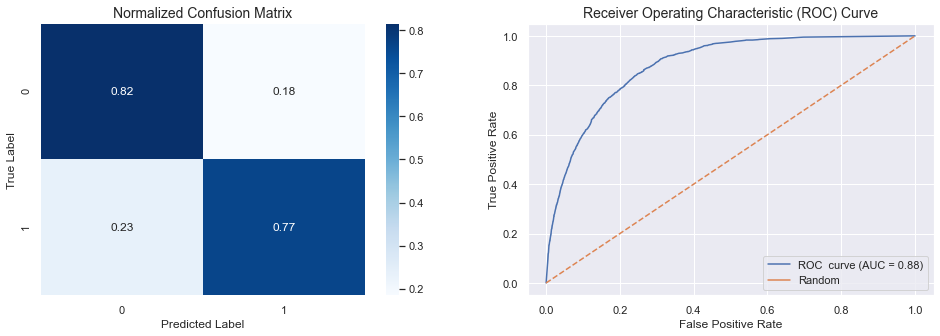

In [723]:
evaluate_model(bag_tuned.best_estimator_, X_train, X_test, y_test, y_train)

In [724]:
print('Optimal Number of Trees:', bag_tuned.best_estimator_.n_estimators)

Optimal Number of Trees: 100


## Random Forests
We observed that even though bagged trees resulted in overall improvement over the initial decision tree, the bagged trees classifier still suffered from high variance. As mentioned before, bagging helps in reducing the variance of an estimator but only if the combined estimators are independent from each other. If they're not, a corresponding covariance term is introduced to the variance of the bagged estimator. Suppose that there's a strong predictor among the features. Since bagging considers all features at every split for every bagged tree, it's likely that this strong predictor will dominate and appear in every tree in the ensemble and hence most of the bagged trees will be similar to each other, which results in correlation between the predictions. Random forests attempts to alleviate this problem by only considering a random subset of the features at every split for each trees. We can think of this process as decorrelating the trees, resulting in a more substantial reduction in variance.

In [725]:
# define the hyperparamter search space
rf_grid = [
  {'max_depth': [5, 10, 20, 30, 40, 50],
   'n_estimators': [20, 50, 100, 150, 250, 500], 
   'max_features':['sqrt', 'log2']}
]

# Create a classifier object with a random forest classifier and 
# hyperparameter candidates, use 5-fold CV
rf_tuned = GridSearchCV(estimator=BalancedRandomForestClassifier(random_state=RANDOM_STATE), 
                        param_grid=rf_grid, 
                        cv=5,
                        n_jobs=-1, 
                        return_train_score=True)

# Train the classifier 
rf_tuned.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=BalancedRandomForestClassifier(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      class_weight=None,
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_samples_leaf=2,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
  

AUC on Training Set:  0.946
AUC on Test Set:  0.9


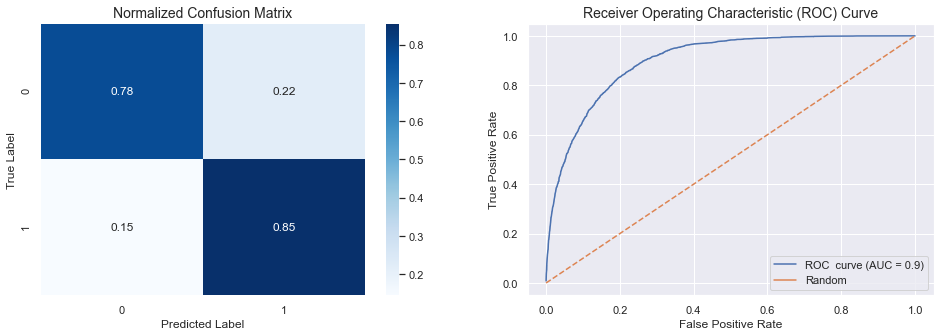

In [726]:
evaluate_model(rf_tuned.best_estimator_, X_train, X_test, y_test, y_train)

In [727]:
print('Optimal Max Depth per Tree:', rf_tuned.best_estimator_.max_depth)
print('Optimal Number of Trees:', rf_tuned.best_estimator_.n_estimators)
print('Optimal Number of Features to consider at each split:', rf_tuned.best_estimator_.max_features, 
      "(" + str(X_train.shape[1]) + ")")

Optimal Max Depth per Tree: 30
Optimal Number of Trees: 250
Optimal Number of Features to consider at each split: sqrt (37)


AUC on Training Set:  0.947
AUC on Test Set:  0.9


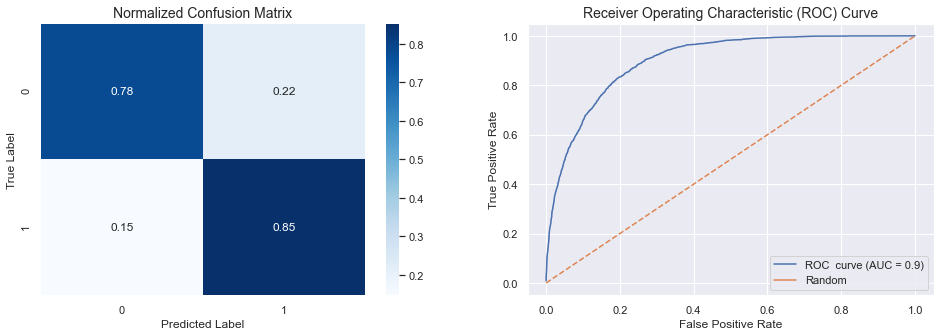

In [728]:
t = BalancedRandomForestClassifier(max_depth=50,
                                   n_estimators=500,
                                   max_features='sqrt',
                                   random_state=RANDOM_STATE)
t.fit(X_train, y_train) 
evaluate_model(t, X_train, X_test, y_test, y_train)

## Boosting
We will now explore a different type of ensemble, which learns sequentially. [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost), which stands for adaptive boosting, starts by weighing each observation in the training set by a factor of $\frac{1}{n}$ where $n$ is the size of the training set. At every iteration, this algorithm adjusts the weights of the training observations, putting more weight on the observations that were misclassified by the previous classifier. This type of learning is particularly useful when the dataset is imbalanced with respect to the class labels. Unlike with Bagging and Random Forests, it's likely that the model will overfit if we use too many trees and if the trees are grown too deep, so we must be careful and tune these hyperparameters having that in mind. As before, we will use a special implementation of AdaBoost called [RUSBoostClassifier](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.RUSBoostClassifier.html) for which during learning, the problem of class balancing is alleviated by random under-sampling the sample at each iteration of the boosting algorithm.

In [729]:
# define the hyperparamter search space
ada_grid = [
  {'base_estimator': [tree.DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE), 
                      tree.DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE), 
                      tree.DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)],
   'n_estimators': [10, 20, 50, 100, 150, 200], 
   'learning_rate': [0.1, 0.01, 0.001]}
]

# Create a classifier object with an adaboost classifier and 
# hyperparameter candidates, use 5-fold CV
tuned_ada = GridSearchCV(estimator=RUSBoostClassifier(random_state=RANDOM_STATE), 
                         param_grid=ada_grid, 
                         cv=5, 
                         n_jobs=-1, 
                         return_train_score=True)

# Train the classifier
tuned_ada.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RUSBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=0, replacement=False,
                                          sampling_strategy='auto'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'base_estimator': [DecisionTreeClassifier(ccp_alpha=0.0,
                                                                    class_weight=None,
                                                                    criterion='gini',
                                                                    max_depth=1,
                                                                    max_features...
                                                                    max_features=None,
                                                                

AUC on Training Set:  0.989
AUC on Test Set:  0.846


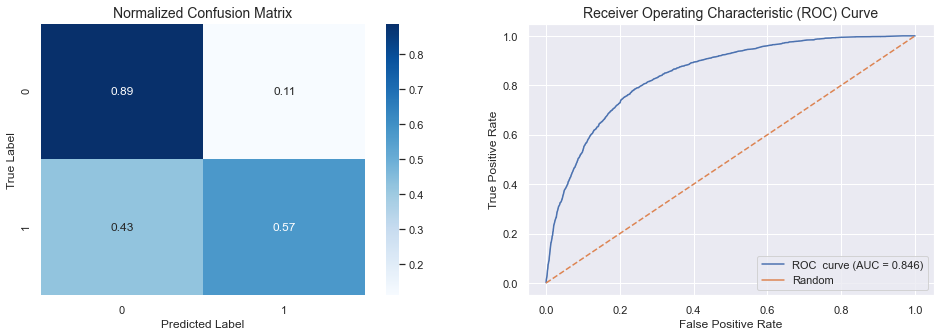

In [730]:
evaluate_model(tuned_ada.best_estimator_, X_train, X_test, y_test, y_train)

In [731]:
print('Optimal Base Estimator:', tuned_ada.best_estimator_.base_estimator)
print('Optimal Number of Trees:', tuned_ada.best_estimator_.n_estimators)
print('Optimal Learning Rate:', tuned_ada.best_estimator_.learning_rate)

Optimal Base Estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
Optimal Number of Trees: 200
Optimal Learning Rate: 0.1


## Ensemble of Ensembles
The [EasyEnsembleClassifier](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html#imblearn.ensemble.EasyEnsembleClassifier) is an ensemble of AdaBoost learners trained on different balanced boostrap samples. The balancing is achieved by random under-sampling.

In [735]:
# define the hyperparamter search space
ee_grid = [
  {'n_estimators': [10, 20, 50, 100, 150, 200]}
]

# Create a classifier object with an easy ensemble classifier and 
# hyperparameter candidates, use 5-fold CV
tuned_ee = GridSearchCV(estimator=EasyEnsembleClassifier(random_state=RANDOM_STATE), 
                        param_grid=ee_grid, 
                        cv=5, 
                        n_jobs=-1, 
                        return_train_score=True)

# Train the classifier
tuned_ee.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=EasyEnsembleClassifier(base_estimator=None,
                                              n_estimators=10, n_jobs=None,
                                              random_state=0, replacement=False,
                                              sampling_strategy='auto',
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'n_estimators': [10, 20, 50, 100, 150, 200]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

AUC on Training Set:  0.896
AUC on Test Set:  0.897


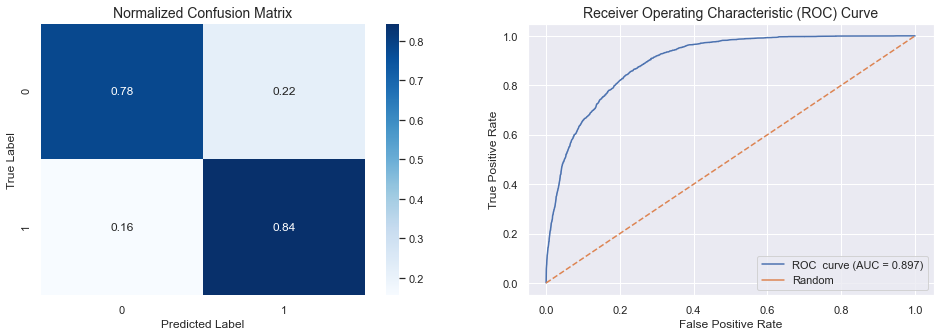

In [736]:
evaluate_model(tuned_ee.best_estimator_, X_train, X_test, y_test, y_train)

In [737]:
print('Optimal Number of Estimators:', tuned_ee.best_estimator_.n_estimators)

Optimal Number of Estimators: 10


# The Winner
As observed, the tuned decision tree model was able to correctly classify **93%** of the individuals with incomes $\le50K$. This is important since this means that this model would be able to accurately reject **93%** of the risky applications and thus the company would be less likely to lose money due to lenders not paying back. On the other hand, this model was only able to correctly classify **57%** of the individuals with incomes $>50K$. This would mean that about **43%** of qualified applicants would get rejected and thus the company would be missing out on good business opportunities.

The **Random Forest** model was able to correctly identify **78%** of the risky applications and **85%** of the safe applications, which is a nice balance. On the other hand, the **Logistic Regression** model was able to correctly identify **78%** of the risky applications and **83%** of the safe applications, which is very comparable to the performance of the **Random Forest** model's performance. The **Logistic Regression** model's variance was practically 0, which suggests that this model might be more reliable, this model is also faster to train and consumes less space than the **Random Forest** model as there's no need to store many estimators (trees). The **Logistic Regression** model is the winner!

# Feature Importance
Time to explore the most relevant features.

In [749]:
# final model is the logistic regression model
final_model = log_model

# we can compare the coefficients since the scale of all variables is the same [0,1]
importances_log = final_model.coef_[0]
feature_importances_log = pd.DataFrame(data={'features':  FEATURES,
                                             'importance': importances_log})\
                                                                  .sort_values(by='importance', 
                                                                   ascending=False)
top_20_log = feature_importances_log.iloc[:20, :]
top_20_log

,features,importance
3,hours-per-week,3.356638
0,age,2.136352
31,relationship_Wife,1.867364
1,capital-gain,1.737986
12,marital-status_Married-civ-spouse,1.386842
4,education,1.321287
19,occupation_Prof-specialty,1.274587
2,capital-loss,1.171026
21,occupation_Exec-managerial,1.137300
18,occupation_Other,0.791970


In [750]:
# lets compare with Random Forest feature importance to see if they agree
importances_rf = rf_tuned.best_estimator_.feature_importances_
feature_importances_rf = pd.DataFrame(data={'features':  FEATURES,
                                            'importance': importances_rf})\
                                                                   .sort_values(by='importance', 
                                                                   ascending=False)

top_20_rf = feature_importances_rf.iloc[:20, :]
top_20_rf

,features,importance
0,age,0.166806
12,marital-status_Married-civ-spouse,0.149233
4,education,0.101071
28,relationship_Husband,0.097879
3,hours-per-week,0.088699
11,marital-status_Never-married,0.057411
1,capital-gain,0.048795
19,occupation_Prof-specialty,0.030498
27,relationship_Own-child,0.024933
21,occupation_Exec-managerial,0.022739


In [751]:
def plot_feature_importance(df, plot_size=(10,8), palette='Blues_r'):
    """
    Plot a bar chart corresponding to the feature importances.
    """
    fig, ax = plt.subplots(figsize=plot_size)
    sns.barplot(y='features', x='importance',
                            data=df,
                            palette=palette)
    ax.set_title('Feature Importance', fontdict=dict(size=20))
    ax.set_ylabel('Feature', fontdict=dict(size=14))
    ax.set_xlabel('Importance', fontdict=dict(size=14))

    plt.show()

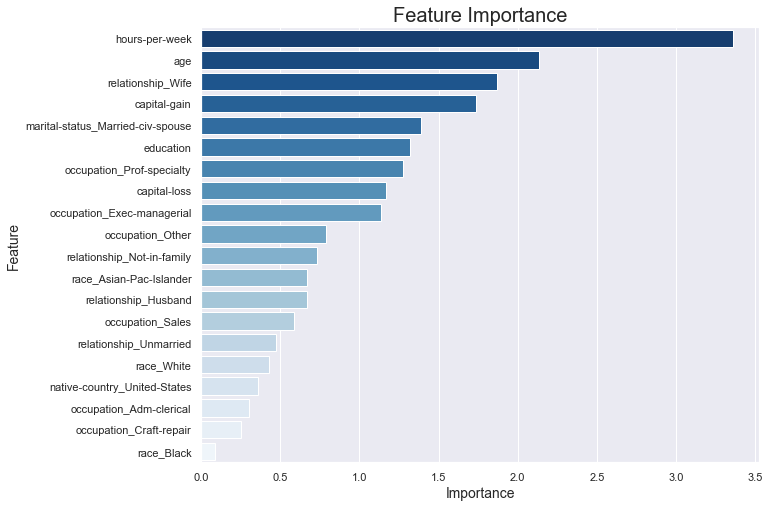

In [752]:
plot_feature_importance(top_20_log)

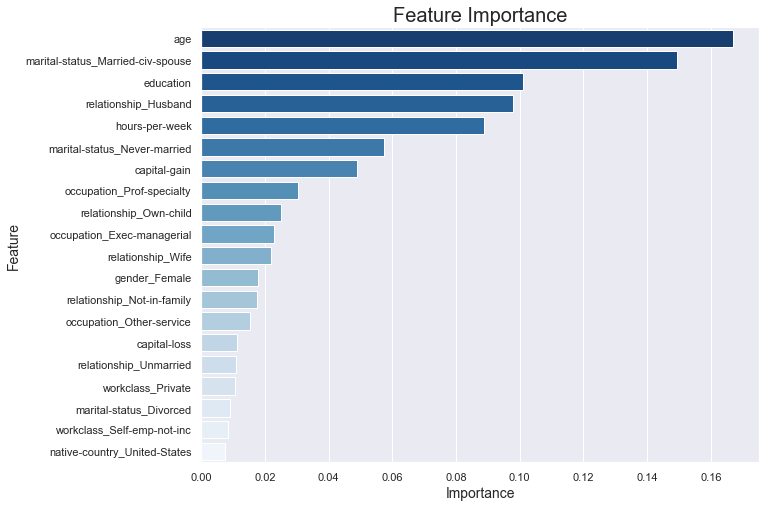

In [753]:
plot_feature_importance(top_20_rf)

It seems that both the **Logistic Regression** model and the **Random Forest** model agree that **age, hours worked per week, education**, and **capital gain** are in the top 10 most important features, which makes sense.

# Building a Machine Learning Pipeline
Now that we've selected our final model, let's build a machine learning pipeline to automate the feature engineering and training process!

In [754]:
final_model

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [153]:
# custom categorical missing value imputer
class CategoricalImputer(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None, replace_with='Missing'):
        self.replace_with = replace_with
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need the fit statement to accomodate the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.variables:   
            X[var] = X[var].str.strip()    
            X[var] = np.where(X[var]=='', self.replace_with, X[var])
            X[var] = np.where(X[var]=='?', self.replace_with, X[var])
            X[var] = X[var].fillna(self.replace_with)

        return X

In [169]:
# build the pipeline
loan_pipeline = Pipeline([
    
    # categorical missing value imputer
    ('categorical_imputer', CategoricalImputer(variables=vars_with_na)),
    
    # frequent label categorical encoder
    ('rare_encoder', ce.RareLabelCategoricalEncoder(tol=0.02, 
                                                    n_categories=4,
                                                    variables=vars_with_rare,
                                                    replace_with='Other', 
                                                    return_object=True)),
    
    # target guided ordinal categorical variable encoder
    ('ordinal_encoder', ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                                     variables=ordinal_features)),
    
    # nominal categorical variable encoder (one hot)
    ('nominal_encoder', ce.OneHotCategoricalEncoder(variables=categorical_features,
                                                    drop_last=True)),
        
    # Yeo-Johnson numerical variable transformer
    ('yeo_johnson_transformer', vt.YeoJohnsonTransformer(variables=numerical_features)),
    
    # scaler
    ('min_max_scaler', MinMaxScaler()),
    
    # logistic regression classifier
    ('log_classifier', LogisticRegression(class_weight='balanced', 
                                          random_state=RANDOM_STATE, 
                                          n_jobs=-1))
])

# Testing the Pipeline
Let's ensure that the pipeline is able to yield the same results obtained without using the pipeline.

In [170]:
# split data into training and test set as before
X_train, X_test, y_train, y_test = train_test_split(
    data[features],
    data[target],
    test_size=0.2,  
    random_state=RANDOM_STATE) 

X_train.shape, X_test.shape

((39073, 12), (9769, 12))

In [171]:
# train the pipeline to the training data
loan_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('categorical_imputer',
                 CategoricalImputer(replace_with='Missing',
                                    variables=['workclass', 'occupation',
                                               'native-country'])),
                ('rare_encoder',
                 RareLabelCategoricalEncoder(n_categories=4,
                                             replace_with='Other',
                                             return_object=True, tol=0.02,
                                             variables=['workclass',
                                                        'education',
                                                        'marital-status',
                                                        'occupation', 'race',
                                                        'native-country'])),
                (...
                                                  'hours-per-week'])),
                ('min_max_scaler',
      

AUC on Training Set:  0.892
AUC on Test Set:  0.891


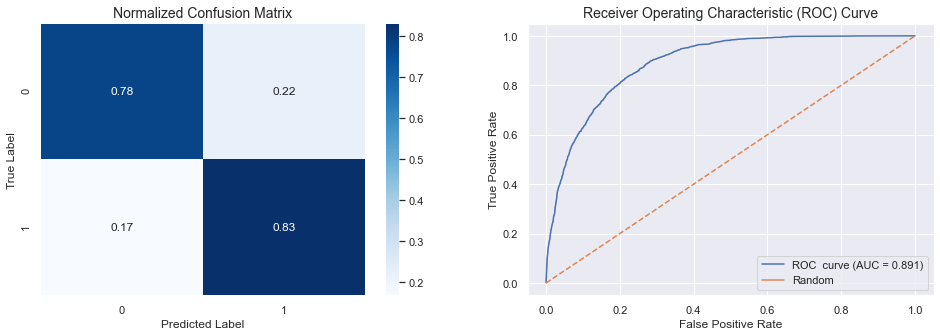

In [172]:
# ensure that the pipeline yields the same result as before
evaluate_model(loan_pipeline, X_train, X_test, y_test, y_train)

In [198]:
single = X_test.iloc[0:1].copy()
print(loan_pipeline.predict(single), loan_pipeline.predict_proba(single))

[0] [[0.57449227 0.42550773]]
